# Analysis: Clustering Archival Metadata Descriptions

## Post Annotation and Aggregation

#### January 2023

**Cluster the the metadata descriptions to see what patterns, if any, appear (didn't work well for annotated text spans, perhaps because the text spans are too short, typically 1-2 words only?).**

*TO DO: Add part-of-speech tags and collection IDs (EADIDs), language of material, & date of material as features to see if that helps find any meaningful patterns in the clusters.*

***

**Table of Contents**

[0.](#0) Preparation

[1.](#1) Clustering Descriptions' Metadata
* K-Means

[2.](#2) Clustering Descriptions' Text
* [K-Means](#kmeans)
* [DBSCAN](#dbscan)
  
***

**References**

For k-Means and DBSCAN: 
* Jurczyk, Thomas (2021) [Clustering with Scikit-Learn in Python](https://programminghistorian.org/en/lessons/clustering-with-scikit-learn-in-python).  The Programming Historian.  https://doi.org/10/46430/phen0094

***

<a id="0"></a>
## 0. Preparation

In [9]:
import utils, config

import re, os
import numpy as np
import pandas as pd

# For working with text data
from nltk.stem import WordNetLemmatizer, PorterStemmer

# For clustering
from sklearn.preprocessing import StandardScaler as SS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN               # algorithms
from sklearn.decomposition import PCA                    # dimensionality reduction
from sklearn.metrics import silhouette_score             # to eval cohesion/separation in a cluster
from sklearn.neighbors import NearestNeighbors           # to get optimal epsilon (neighborhood distance) value

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# from yellowbrick.cluster import SilhouetteVisualizer  #--> installed inside and outside virtual env, still not working...

In [2]:
df = pd.read_csv(config.crc_meta_path+"annot_descs.csv", index_col=0)
df = df.loc[df.field != "Identifier"] # Ignore the Identifier field rows
df = df.loc[~df.clean_desc.isna()]    # Ignore empty clean_desc rows (the field's descriptions appear in the next row)
df = df[["field", "clean_desc", "word_count", "sent_count"]]
df.head()

,field,clean_desc,word_count,sent_count
1,Title,Papers of The Very Rev Prof James Whyte (1920-...,10,1
2,Scope and Contents,"Sermons and addresses, 1948-1996; lectures, 19...",65,1
3,Biographical / Historical,Professor James Aitken White was a leading Sco...,181,8
5,Title,Papers of Rev Tom Allan (1916-1965),7,1
6,Scope and Contents,"Sermons and addresses, 1947-1963; essays and l...",62,2


Let's summarize the data:

In [3]:
text_col = "clean_desc"
print("Total texts:", df.shape[0])
print("Unique texts:", len(df[text_col].unique()))

Total texts: 27312
Unique texts: 23607


In [4]:
df[["word_count","sent_count"]].describe()

,word_count,sent_count
count,27312.000000,27312.000000
mean,20.412419,1.517062
std,87.910588,5.420943
min,0.000000,1.000000
25%,6.000000,1.000000
50%,11.000000,1.000000
75%,20.000000,1.000000
max,12343.000000,742.000000


In [5]:
print("Descriptions with 700+ sentences:", df.loc[df.sent_count >= 700].shape[0])
print("Descriptions with 5+ sentences:", df.loc[df.sent_count >= 5].shape[0])
print("Descriptions with 2+ sentences:", df.loc[df.sent_count >= 2].shape[0])

Descriptions with 700+ sentences: 1
Descriptions with 5+ sentences: 649
Descriptions with 2+ sentences: 5692


Let's remove the outliers that are particularly long from the data we'll cluster:

In [6]:
ninety_quantile = df["word_count"].quantile(0.9)
df = df.loc[df["word_count"] <= ninety_quantile]
print(df.shape)
df[["word_count","sent_count"]].describe()

(24637, 4)


,word_count,sent_count
count,24637.000000,24637.000000
mean,12.075780,1.193327
std,7.795105,0.550066
min,0.000000,1.000000
25%,5.000000,1.000000
50%,10.000000,1.000000
75%,17.000000,1.000000
max,33.000000,10.000000


Great!  The standard deviation for word and sentence counts has been reduced significantly.

<a id="1"></a>
## 1. Clustering Descriptions' Metadata

### K-Means

Use sklearn's StandardScaler to normalize the data, casting the mean of the columns to about 0 and the standard deviation to about 1.

In [7]:
scaler = SS()
norm = scaler.fit_transform(df[["word_count", "sent_count"]])
df_norm = pd.DataFrame(norm, columns=["word_count_normalized", "sent_count_normalized"])
df_norm = df_norm.set_index(df.index)
fields_dict = {"Title":0, "Scope and Contents":1, "Biographical / Historical": 3, "Processing Information":4}
numeric_fields = [fields_dict[field] for field in list(df.field)]
df_norm.insert(0, "field", numeric_fields)
# df_norm.insert(1, "clean_desc", df.clean_desc)
df_norm.head()

,field,word_count_normalized,sent_count_normalized
1,0,-0.266298,-0.351469
5,0,-0.651163,-0.351469
9,0,-0.394586,-0.351469
13,0,-0.266298,-0.351469
14,0,-0.907739,-0.351469


Select **up to 3 features** from the available columns of data (field, word_count, sent_count):

In [10]:
selected_features = utils.progressiveFeaturesSelection(df_norm, max_features=3, n_clusters=3)

Proposed new feature field with score 0.9955026689581135
Proposed new feature word_count_normalized with score 0.6083092027966975
Proposed new feature sent_count_normalized with score 0.9675768062993427
Initial feature: field | Silhouette score: 0.9955026689581135
Starting selection 0...
Proposed new feature word_count_normalized with score 0.5432571995298702
Proposed new feature sent_count_normalized with score 0.8634727730354189
Selected new feature sent_count_normalized with score 0.8634727730354189
Starting selection 1...
Proposed new feature word_count_normalized with score 0.5281844827383453
Selected new feature word_count_normalized with score 0.5281844827383453


In [12]:
print(selected_features)

['field', 'sent_count_normalized', 'word_count_normalized']


In [25]:
subdf_norm = df_norm[selected_features]
subdf_norm.head()

,field,sent_count_normalized,word_count_normalized
1,0,-0.351469,-0.266298
5,0,-0.351469,-0.651163
9,0,-0.351469,-0.394586
13,0,-0.351469,-0.266298
14,0,-0.351469,-0.907739


/afs/inf.ed.ac.uk/user/s15/s1545703/repos/gender-bias/analysis/Clustering/utils.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


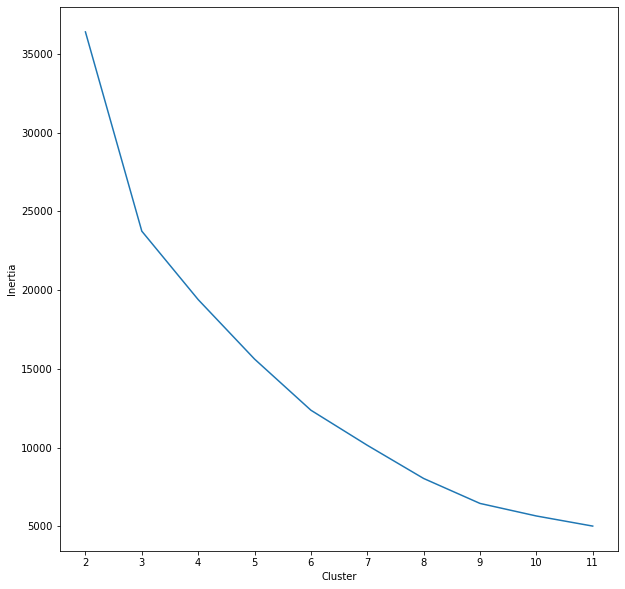

In [26]:
utils.elbowPlot(range(2,12), subdf_norm)

In [27]:
kmeans = KMeans(n_clusters=3, random_state=22)
descs_clusters = kmeans.fit_predict(subdf_norm)
subdf_norm .insert(len(subdf_norm.columns), "cluster", descs_clusters)
subdf_norm.head()

,field,sent_count_normalized,word_count_normalized,cluster
1,0,-0.351469,-0.266298,1
5,0,-0.351469,-0.651163,1
9,0,-0.351469,-0.394586,1
13,0,-0.351469,-0.266298,1
14,0,-0.351469,-0.907739,1


In [28]:
pca = PCA(n_components=2, whiten=False, random_state=22)
norm_pca = pca.fit_transform(subdf_norm)
df_norm_pca = pd.DataFrame(data=norm_pca, columns=["pc_1", "pc_2"])
df_norm_pca.insert(len(df_norm_pca.columns), "cluster", descs_clusters)
df_norm_pca.head()

,pc_1,pc_2,cluster
0,-0.512818,0.191078,1
1,-0.769747,0.398581,1
2,-0.598461,0.260246,1
3,-0.512818,0.191078,1
4,-0.941033,0.536916,1


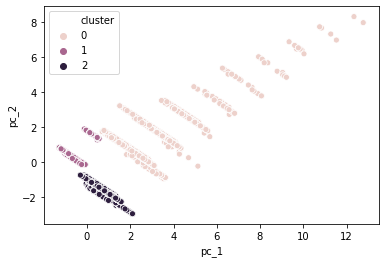

In [29]:
sns.scatterplot(x="pc_1", y="pc_2", hue="cluster", data=df_norm_pca)

Let's investigate the clusters:

In [30]:
df_joined = subdf_norm.join(df, lsuffix="_norm", rsuffix="")
df_joined.head()

,field_norm,sent_count_normalized,word_count_normalized,cluster,field,clean_desc,word_count,sent_count
1,0,-0.351469,-0.266298,1,Title,Papers of The Very Rev Prof James Whyte (1920-...,10,1
5,0,-0.351469,-0.651163,1,Title,Papers of Rev Tom Allan (1916-1965),7,1
9,0,-0.351469,-0.394586,1,Title,Papers of Rev Prof Alec Campbell Cheyne (1924-...,9,1
13,0,-0.351469,-0.266298,1,Title,"Papers of Professor John Baillie, and Baillie ...",10,1
14,0,-0.351469,-0.907739,1,Title,Papers of John Baillie,5,1


Unnormalized Description Word and Sentence Counts


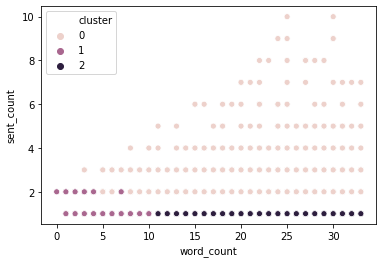

In [31]:
print("Unnormalized Description Word and Sentence Counts")
sns.scatterplot(x="word_count", y="sent_count", hue="cluster", data=df_joined)

In [32]:
df0 = df_joined.loc[df_joined.cluster == 0]
print(df0.shape)
print(df0.field.value_counts())
print("Range of word count:", min(df0.word_count), max(df0.word_count))
print("Range of sentence count:", min(df0.sent_count), max(df0.sent_count))

(3342, 8)
Scope and Contents           2410
Title                         857
Biographical / Historical      60
Processing Information         15
Name: field, dtype: int64
Range of word count: 3 33
Range of sentence count: 2 10


In [33]:
df1 = df_joined.loc[df_joined.cluster == 1]
print(df1.shape)
print(df1.field.value_counts())
print("Range of word count:", min(df1.word_count), max(df1.word_count))
print("Range of sentence count:", min(df1.sent_count), max(df1.sent_count))

(14050, 8)
Title                 13007
Scope and Contents     1043
Name: field, dtype: int64
Range of word count: 0 15
Range of sentence count: 1 2


In [34]:
df2 = df_joined.loc[df_joined.cluster == 2]
print(df2.shape)
print(df2.field.value_counts())
print("Range of word count:", min(df2.word_count), max(df2.word_count))
print("Range of sentence count:", min(df2.sent_count), max(df2.sent_count))

(7245, 8)
Scope and Contents           5696
Title                        1086
Processing Information        285
Biographical / Historical     178
Name: field, dtype: int64
Range of word count: 6 33
Range of sentence count: 1 1


Observations:
* Cluster 0 is the smallest (and least cohesive)
* Cluster 1 is the largest
* Cluster 2 is the most cohesive
* Clusters 0 & 2 have descriptions from all metadata fields; cluster 1, from Title & Scope and Contents only
* All three clusters have overlapping word count ranges
* Cluster 1's sentence count range overlaps with clusters 0 and 2, but clusters 0 and 2's sentence count ranges do not overlap

<a id="2"></a>
## 2. Clustering Descriptions' Text

Set the maximum number of features at 250, and only consider words that appear in at least 50 different documents but no more than 300.  Additionally, allow for bigrams (such as "19th century") and trigrams (such as "Mrs. Norman Macleod").  We'll have the sklearn Vectorizer filter out stop words (such as "the" and "and"), as well.

*Question: How are the features selected if a maximum is set?*

In [149]:
col_name = "clean_desc" #clean_desc_lemmas, clean_desc_stems  #text, text_stems, text_lemmas
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=250, strip_accents="unicode", min_df=50, max_df=300, stop_words="english")
tfidf_array = tfidf.fit_transform(df[col_name])
df_tfidf = pd.DataFrame(tfidf_array.toarray(), index=df.index, columns=tfidf.get_feature_names())
df_tfidf.describe()

,10,2p,5cmsent,account,africa,agricultural,alan,alpbach,alpbach austria,alternative,...,water lane farmhouse,west,white,william,wilmut,woman,work,year,years,young
count,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,...,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000
mean,0.003227,0.003813,0.006177,0.003974,0.004738,0.002814,0.003122,0.004918,0.002172,0.002805,...,0.003290,0.003938,0.005080,0.002941,0.006642,0.005699,0.003051,0.003682,0.003670,0.005360
std,0.049154,0.052477,0.071613,0.051887,0.058126,0.042732,0.048556,0.058445,0.032914,0.041596,...,0.035079,0.055415,0.062067,0.047890,0.067209,0.065381,0.047589,0.052042,0.053629,0.063442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.594800,1.000000,...,0.448131,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [150]:
df_tfidf.shape

(24637, 250)

<a id="kmeans"></a>
### K-Means

Next, use Principal Component Analysis (PCA) to reduce the dimensions in our dataset from 250 to 10.

In [151]:
pca = PCA(n_components=10, whiten=False, random_state=22)
descs_pca = pca.fit_transform(df_tfidf)
df_pca = pd.DataFrame(data=descs_pca)

In [152]:
print(df_pca.shape)
df_pca.head()

(24637, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.007588,-0.028285,-0.007588,-0.031365,-0.023552,-0.043465,-0.034558,-0.032539,0.048489,0.124282
1,-0.000965,-0.005132,-0.000144,-0.003531,-0.002667,-0.006349,-0.002286,0.002328,0.005173,-0.002468
2,-0.000965,-0.005132,-0.000144,-0.003531,-0.002667,-0.006349,-0.002286,0.002328,0.005173,-0.002468
3,-0.007411,-0.010439,0.006006,-0.055420,-0.013338,-0.172065,-0.076537,-0.114363,-0.069871,-0.072084
4,-0.006211,-0.009478,0.006018,-0.056942,-0.012249,-0.179610,-0.088177,-0.114423,-0.079339,-0.080941


/afs/inf.ed.ac.uk/user/s15/s1545703/repos/gender-bias/analysis/Clustering/utils.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


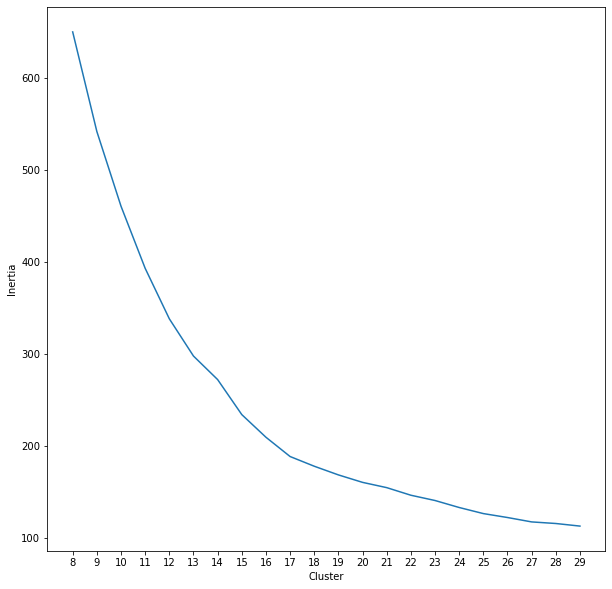

In [157]:
utils.elbowPlot(range(8, 30), df_pca)

In [158]:
kmeans = KMeans(n_clusters=17, random_state=22)  #4
descs_clusters = kmeans.fit_predict(df_pca)
df_clustered = df.copy()
df_clustered.insert(len(df.columns), "cluster", descs_clusters)
df_clustered.head()

,field,clean_desc,word_count,sent_count,clean_desc_lemmas,cluster
1,Title,Papers of The Very Rev Prof James Whyte (1920-...,10,1,Papers of The Very Rev Prof James Whyte (1920-...,1
5,Title,Papers of Rev Tom Allan (1916-1965),7,1,Papers of Rev Tom Allan (1916-1965),1
9,Title,Papers of Rev Prof Alec Campbell Cheyne (1924-...,9,1,Papers of Rev Prof Alec Campbell Cheyne (1924-...,1
13,Title,"Papers of Professor John Baillie, and Baillie ...",10,1,"Papers of Professor John Baillie, and Baillie ...",11
14,Title,Papers of John Baillie,5,1,Papers of John Baillie,11


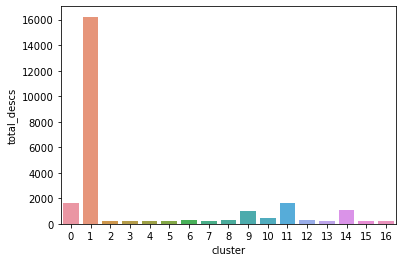

In [159]:
cluster_sizes = df_clustered.groupby("cluster").size().reset_index(name="total_descs").sort_values(by="total_descs")
sns.barplot(x="cluster", y="total_descs", data=cluster_sizes)

We have 1 very large cluster, about 4 medium clusters, and 11 small clusters.

In [79]:
for cluster in range(17):
    print("Cluster {}".format(cluster))
    print("--------------")
    cluster = df_clustered.loc[df_clustered.cluster == cluster]
    print(cluster.field.value_counts(), "\n")

Cluster 0
--------------
Scope and Contents           1053
Title                         554
Biographical / Historical       2
Name: field, dtype: int64 

Cluster 1
--------------
Title                        11399
Scope and Contents            4547
Biographical / Historical      182
Processing Information         101
Name: field, dtype: int64 

Cluster 2
--------------
Title    203
Name: field, dtype: int64 

Cluster 3
--------------
Title                        177
Scope and Contents            77
Biographical / Historical      1
Name: field, dtype: int64 

Cluster 4
--------------
Scope and Contents    232
Name: field, dtype: int64 

Cluster 5
--------------
Title                 198
Scope and Contents     16
Name: field, dtype: int64 

Cluster 6
--------------
Title                 283
Scope and Contents      3
Name: field, dtype: int64 

Cluster 7
--------------
Scope and Contents    251
Name: field, dtype: int64 

Cluster 8
--------------
Scope and Contents    200
Title          

***
#### **TO DO:** perform text mining on the clusters, and associate descriptions to collections to see if collections or certain topics (people, research, education, etc.) are clustering together
***

Reduce to 2 dimensions instead of 10 to visualize the clusters:

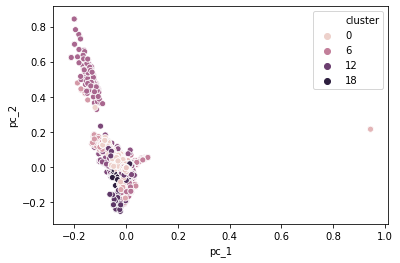

In [82]:
pca = PCA(n_components=2, whiten=False, random_state=22)
descs_pca2 = pca.fit_transform(df_tfidf)
df_pca2 = pd.DataFrame(data=descs_pca2, columns=["pc_1", "pc_2"])
df_pca2.insert(len(df_pca2.columns), "cluster", descs_clusters)
# df_pca2.head()
sns.scatterplot(x="pc_1", y="pc_2", hue="cluster", data=df_pca2)

<a id="dbscan"></a>
### DBSCAN

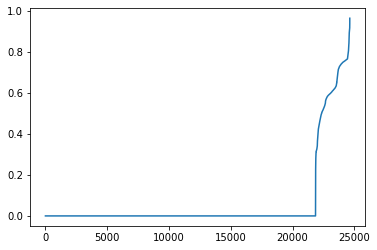

In [51]:
utils.findOptimalEps(2, df_tfidf)

Let's try 0.6 as the epsilon value:

In [52]:
dbscan = DBSCAN(eps=0.6, metric="euclidean")  # change to cosine distance if use TFIDF DataFrame
dbscan_clusters = dbscan.fit_predict(df_pca)
df_dbscan = df.copy()
df_dbscan.insert(len(df_dbscan.columns), "cluster", dbscan_clusters)
df_dbscan["cluster"].unique()

array([0])

In [53]:
dbscan = DBSCAN(eps=0.6, metric="cosine")  # change to Euclidean distance if use PCA DataFrame
dbscan_clusters = dbscan.fit_predict(df_tfidf)
df_dbscan = df.copy()
df_dbscan.insert(len(df_dbscan.columns), "cluster", dbscan_clusters)
df_dbscan["cluster"].unique()

array([-1,  0,  1])

In [54]:
df_dbscan.head()

,field,clean_desc,word_count,sent_count,clean_desc_lemmas,cluster
1,Title,Papers of The Very Rev Prof James Whyte (1920-...,10,1,Papers of The Very Rev Prof James Whyte (1920-...,-1
5,Title,Papers of Rev Tom Allan (1916-1965),7,1,Papers of Rev Tom Allan (1916-1965),-1
9,Title,Papers of Rev Prof Alec Campbell Cheyne (1924-...,9,1,Papers of Rev Prof Alec Campbell Cheyne (1924-...,-1
13,Title,"Papers of Professor John Baillie, and Baillie ...",10,1,"Papers of Professor John Baillie, and Baillie ...",0
14,Title,Papers of John Baillie,5,1,Papers of John Baillie,0


Reduce to two dimensions for visualization:

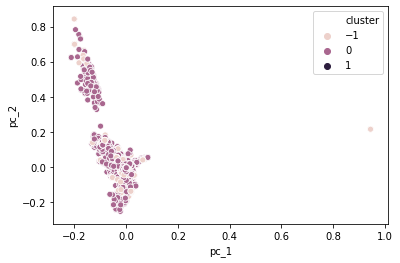

In [91]:
pca = PCA(n_components=2, whiten=False, random_state=22)
descs_pca3 = pca.fit_transform(df_tfidf)
df_dbscan = pd.DataFrame(data=descs_pca3, columns=["pc_1", "pc_2"])
df_dbscan.insert(len(df_dbscan.columns), "cluster", dbscan_clusters)
# df_dbscan.head()
sns.scatterplot(x="pc_1", y="pc_2", hue="cluster", data=df_dbscan)

#### WITH LEMMAS:

In [58]:
# stemmer = PorterStemmer()
# text_list = list(df[text_col])
# text_stems = [stemmer.stem(text) for text in text_list]
# print(text_stems[0])

lmtzr = WordNetLemmatizer()
text_list = list(df[text_col])
text_lemmas = [lmtzr.lemmatize(text) for text in text_list]
print(text_lemmas[0])

Papers of The Very Rev Prof James Whyte (1920-2005)


In [92]:
# df.insert(len(df.columns), "clean_desc_stems", text_stems)
# df.insert(len(df.columns), "clean_desc_lemmas", text_lemmas)
df.head()

,field,clean_desc,word_count,sent_count,clean_desc_lemmas
1,Title,Papers of The Very Rev Prof James Whyte (1920-...,10,1,Papers of The Very Rev Prof James Whyte (1920-...
5,Title,Papers of Rev Tom Allan (1916-1965),7,1,Papers of Rev Tom Allan (1916-1965)
9,Title,Papers of Rev Prof Alec Campbell Cheyne (1924-...,9,1,Papers of Rev Prof Alec Campbell Cheyne (1924-...
13,Title,"Papers of Professor John Baillie, and Baillie ...",10,1,"Papers of Professor John Baillie, and Baillie ..."
14,Title,Papers of John Baillie,5,1,Papers of John Baillie


***

Set the maximum number of features at 300, and only consider words that appear in at least 20 different documents but no more than 200.  Additionally, allow for bigrams (such as "19th century") and trigrams (such as "Mrs. Norman Macleod").  We'll have the sklearn Vectorizer filter out stop words (such as "the" and "and"), as well.

*Question: How are the features selected if a maximum is set?*

In [95]:
col_name = "clean_desc_lemmas" #clean_desc, clean_desc_stems  #text, text_stems, text_lemmas
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=300, strip_accents="unicode", min_df=20, max_df=200, stop_words="english")
tfidf_array = tfidf.fit_transform(df[col_name])
df_tfidf = pd.DataFrame(tfidf_array.toarray(), index=df.index, columns=tfidf.get_feature_names())
df_tfidf.describe()

,10,12,2003,2p,5cmsent,account,africa,africa early,age,agricultural,...,wales,west,white,william,work,year,years,yorksent,young,zealand
count,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,...,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000,24637.000000
mean,0.003269,0.002745,0.002515,0.003885,0.006302,0.003687,0.004819,0.002127,0.002270,0.002732,...,0.002454,0.003786,0.004817,0.003051,0.003240,0.003897,0.003735,0.002157,0.005765,0.002094
std,0.049753,0.045733,0.042226,0.053767,0.073035,0.048332,0.059506,0.036790,0.041456,0.041896,...,0.042314,0.053413,0.058627,0.049655,0.050493,0.054414,0.054455,0.036014,0.068009,0.035621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.746358,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.707107,1.000000,0.707107


In [96]:
df_tfidf.shape

(24637, 300)

<a id="kmeans"></a>
### K-Means

Next, use Principal Component Analysis (PCA) to reduce the dimensions in our dataset from 300 to 5.

In [121]:
pca = PCA(n_components=5, whiten=False, random_state=22)
descs_pca = pca.fit_transform(df_tfidf)
df_pca = pd.DataFrame(data=descs_pca)

In [122]:
print(df_pca.shape)
df_pca.head()

(24637, 5)


,0,1,2,3,4
0,-0.001899,-0.002653,-0.000317,-0.000787,-0.000656
1,-0.001899,-0.002653,-0.000317,-0.000787,-0.000656
2,-0.001899,-0.002653,-0.000317,-0.000787,-0.000656
3,-0.018023,-0.017455,-0.049967,0.033579,0.068183
4,-0.022919,-0.033814,-0.066755,0.053599,0.075385


/afs/inf.ed.ac.uk/user/s15/s1545703/repos/gender-bias/analysis/Clustering/utils.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


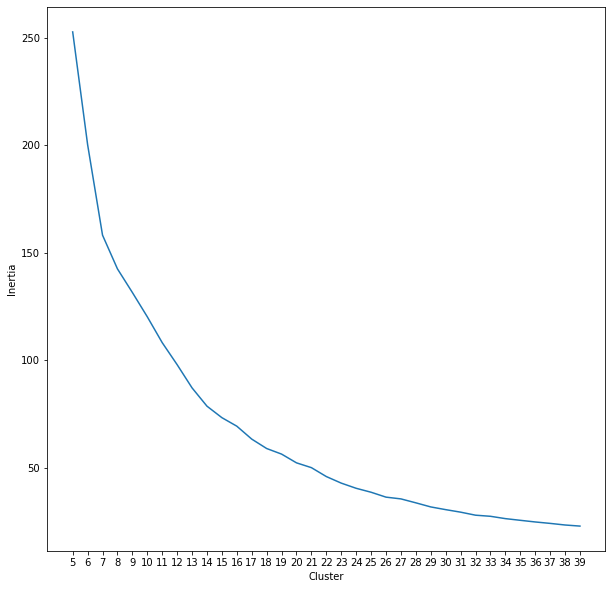

In [124]:
utils.elbowPlot(range(5, 40), df_pca)

In [133]:
n_clusters = 7 #14

In [134]:
kmeans = KMeans(n_clusters=n_clusters, random_state=22)
descs_clusters = kmeans.fit_predict(df_pca)
df_clustered = df.copy()
df_clustered.insert(len(df.columns), "cluster", descs_clusters)
df_clustered.head()

,field,clean_desc,word_count,sent_count,clean_desc_lemmas,cluster
1,Title,Papers of The Very Rev Prof James Whyte (1920-...,10,1,Papers of The Very Rev Prof James Whyte (1920-...,1
5,Title,Papers of Rev Tom Allan (1916-1965),7,1,Papers of Rev Tom Allan (1916-1965),1
9,Title,Papers of Rev Prof Alec Campbell Cheyne (1924-...,9,1,Papers of Rev Prof Alec Campbell Cheyne (1924-...,1
13,Title,"Papers of Professor John Baillie, and Baillie ...",10,1,"Papers of Professor John Baillie, and Baillie ...",1
14,Title,Papers of John Baillie,5,1,Papers of John Baillie,1


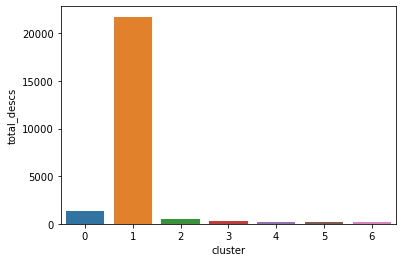

In [135]:
cluster_sizes = df_clustered.groupby("cluster").size().reset_index(name="total_descs").sort_values(by="total_descs")
sns.barplot(x="cluster", y="total_descs", data=cluster_sizes)

We still get 1 cluster significantly larger than the others.

In [136]:
for cluster in range(n_clusters):
    print("Cluster {}".format(cluster))
    print("--------------")
    cluster = df_clustered.loc[df_clustered.cluster == cluster]
    print(cluster.field.value_counts(), "\n")

Cluster 0
--------------
Scope and Contents        721
Title                     463
Processing Information    199
Name: field, dtype: int64 

Cluster 1
--------------
Title                        13693
Scope and Contents            7729
Biographical / Historical      238
Processing Information         101
Name: field, dtype: int64 

Cluster 2
--------------
Scope and Contents    272
Title                 259
Name: field, dtype: int64 

Cluster 3
--------------
Scope and Contents    313
Title                  26
Name: field, dtype: int64 

Cluster 4
--------------
Title                 186
Scope and Contents      5
Name: field, dtype: int64 

Cluster 5
--------------
Scope and Contents    105
Title                  94
Name: field, dtype: int64 

Cluster 6
--------------
Title                 229
Scope and Contents      4
Name: field, dtype: int64 



***
#### **TO DO:** perform text mining on the clusters, and associate descriptions to collections to see if collections or certain topics (people, research, education, etc.) are clustering together
***

Reduce to 2 dimensions instead of 10 to visualize the clusters:

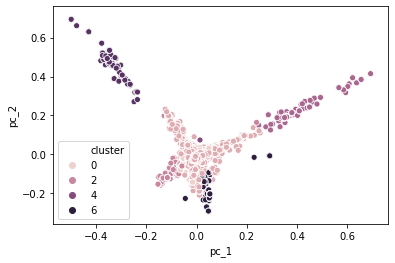

In [137]:
pca = PCA(n_components=2, whiten=False, random_state=22)
descs_pca2 = pca.fit_transform(df_tfidf)
df_pca2 = pd.DataFrame(data=descs_pca2, columns=["pc_1", "pc_2"])
df_pca2.insert(len(df_pca2.columns), "cluster", descs_clusters)
# df_pca2.head()
sns.scatterplot(x="pc_1", y="pc_2", hue="cluster", data=df_pca2)

<a id="dbscan"></a>
### DBSCAN

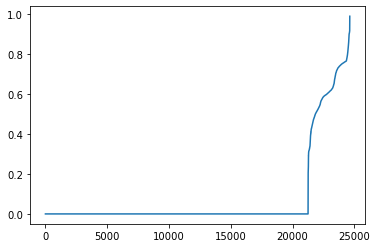

In [138]:
utils.findOptimalEps(2, df_tfidf)

In [139]:
eps_value = 0.7  # 0.6

In [140]:
dbscan = DBSCAN(eps=eps_value, metric="euclidean")  # change to cosine distance if use TFIDF DataFrame
dbscan_clusters = dbscan.fit_predict(df_pca)
df_dbscan = df.copy()
df_dbscan.insert(len(df_dbscan.columns), "cluster", dbscan_clusters)
df_dbscan["cluster"].unique()

array([0])

In [142]:
dbscan = DBSCAN(eps=0.6, metric="cosine")  # change to Euclidean distance if use PCA DataFrame
dbscan_clusters = dbscan.fit_predict(df_tfidf)
df_dbscan = df_dbscan.drop(columns="cluster")
df_dbscan.insert(len(df_dbscan.columns), "cluster", dbscan_clusters)
df_dbscan["cluster"].unique()

array([-1,  0,  1,  2])

In [143]:
df_dbscan.head()

,field,clean_desc,word_count,sent_count,clean_desc_lemmas,cluster
1,Title,Papers of The Very Rev Prof James Whyte (1920-...,10,1,Papers of The Very Rev Prof James Whyte (1920-...,-1
5,Title,Papers of Rev Tom Allan (1916-1965),7,1,Papers of Rev Tom Allan (1916-1965),-1
9,Title,Papers of Rev Prof Alec Campbell Cheyne (1924-...,9,1,Papers of Rev Prof Alec Campbell Cheyne (1924-...,-1
13,Title,"Papers of Professor John Baillie, and Baillie ...",10,1,"Papers of Professor John Baillie, and Baillie ...",0
14,Title,Papers of John Baillie,5,1,Papers of John Baillie,0


Visualize the cluster sizes in a bar chart:

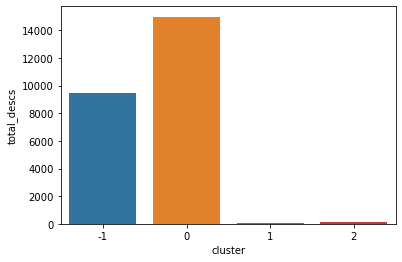

In [145]:
dbscan_cluster_sizes = df_dbscan.groupby("cluster").size().reset_index(name="total_descs").sort_values(by="total_descs")
sns.barplot(x="cluster", y="total_descs", data=dbscan_cluster_sizes)

We have 2 large clusters and 2 small clusters.

In [146]:
dbscan_cluster_sizes

,cluster,total_descs
2,1,85
3,2,127
0,-1,9441
1,0,14984


***
#### **TO DO:** perform text mining on the clusters, and associate descriptions to collections to see if collections or certain topics (people, research, education, etc.) are clustering together
***

In [148]:
# ### Not a helpful viz ###
# # Reduce to two dimensions for scatterplot visualization:
# pca = PCA(n_components=2, whiten=False, random_state=22)
# descs_pca3 = pca.fit_transform(df_tfidf)
# df_dbscan = pd.DataFrame(data=descs_pca3, columns=["pc_1", "pc_2"])
# df_dbscan.insert(len(df_dbscan.columns), "cluster", dbscan_clusters)
# # df_dbscan.head()
# sns.scatterplot(x="pc_1", y="pc_2", hue="cluster", data=df_dbscan)